In [3]:
%load_ext autoreload
%config Completer.use_jedi = False

In [4]:
%autoreload 2
import FEMOL
import numpy as np
np.set_printoptions(linewidth=200)
import matplotlib.pyplot as plt
import pyvista
import meshio
import pygmsh
import scipy.ndimage
pyvista.set_jupyter_backend('pythreejs')

# Quarter plate optimization problem with pipeline for 3D printing composite material core

## 1. Solve the topology optimization problem

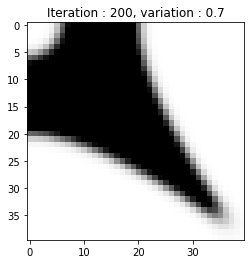

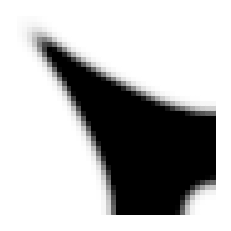

In [3]:
# Mesh
nelx = 40
nely = 40
Lx = nelx
Ly = nely
mesh = FEMOL.mesh.rectangle_Q4(nelx, nely, Lx, Ly)

# FEM Problem
plate_FEM = FEMOL.FEM_Problem('displacement', 'plate', mesh)

# Define the composite material layups
flax_base = FEMOL.materials.general_flax()
layup_base = FEMOL.laminate.Layup(flax_base, plies=[0, -45, 90, 45], symetric=True)
carbon_coating = FEMOL.materials.general_carbon()
layup_coating = FEMOL.laminate.Layup(carbon_coating, plies=[0, 90], h_core=10)

plate_FEM.define_materials(flax_base, carbon_coating)
plate_FEM.define_tensors(layup_base, layup_coating)

# Define the boundary conditions
fixed_domain = FEMOL.domains.inside_box([Lx], [[0, Ly]])
plate_FEM.add_fixed_domain(fixed_domain, ddls=[2])

fixed_domain = FEMOL.domains.inside_box([[0, Lx]], [0])
plate_FEM.add_fixed_domain(fixed_domain, ddls=[2])

fixed_domain = FEMOL.domains.inside_box([[0, Lx]], [Ly])
plate_FEM.add_fixed_domain(fixed_domain, ddls = [1])

fixed_domain = FEMOL.domains.inside_box([ 0], [[0, Ly]])
plate_FEM.add_fixed_domain(fixed_domain, ddls = [0])

# Define the applied force
force = [0, 0, -500, 0, 0, 0]
force_domain = FEMOL.domains.inside_box([[0, Lx/10]], [[9*Ly/10, Ly]])
plate_FEM.add_forces(force, force_domain)

topo_problem = FEMOL.TOPOPT_Problem(plate_FEM, volfrac=0.4, penal=1.5, method='SIMP')
mesh = topo_problem.solve(plot=True, max_loops=200, converge=0.005)

mesh.plot.cell_data('X')

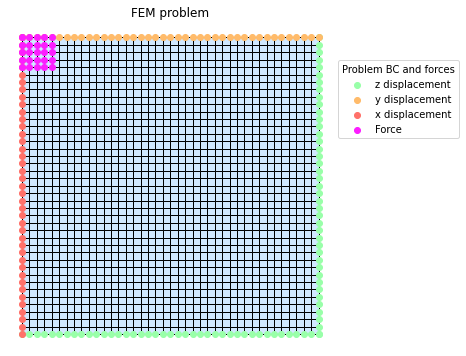

In [31]:
plate_FEM.plot()

## 2. Export the result to .gcode

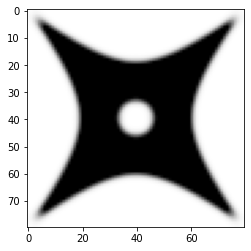

In [25]:
# Reshape into full plate
X = mesh.cell_data['X']['quad'].reshape(40, 40)
X2 = np.hstack([np.flip(X, axis=1), X])
X3 = np.vstack([X2, np.flip(X2, axis=0)])
plt.imshow(X3, cmap='Greys')

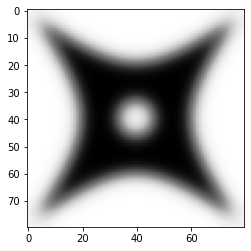

In [26]:
# Smoothen the boundaries
X4 = scipy.ndimage.gaussian_filter(X3, sigma=3)
plt.imshow(X4, cmap='Greys')

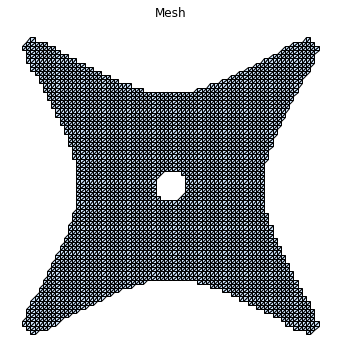

In [28]:
# Create a mesh to support the height data
new_mesh = FEMOL.mesh.rectangle_Q4(Lx=150, Ly=150, nelx=79, nely=79)
points = np.vstack([new_mesh.points.T, X4.reshape(-1)*10, ])
points = points.T

new_cells = []
for cell in new_mesh.plot.all_tris:
    if (points[cell][:,2] > 3).all():
        new_cells.append(cell)
cell_dict = {'triangle': np.array(new_cells)}
mesh2 = FEMOL.Mesh(points, cell_dict)
mesh2.display()   

In [29]:
# Save the mesh with height data and visualize it in 3D
cells = [('triangle', mesh2.plot.all_tris)]
points[:, 2] = points[:, 2]-3
mesh3 = meshio.Mesh(points, cells)
mesh3.write('quarter_plate_core_3.vtk')
pv_mesh = pyvista.read('quarter_plate_core_3.vtk')
pv_mesh.plot()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(color='#fefefe', inten…

In [30]:
# Save the mesh to STL
mesh3.write('print_core_test.stl')

In [7]:
# TODO : Create the gcode with CuraEngine

In [5]:
pv_mesh = pyvista.read('quarter_plate_core_3.vtk')
pv_mesh.plot()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(color='#fefefe', inten…